<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/master/merge_set_4class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [3]:
# from google.colab import drive

# from pathlib import Path
# import sys
# drive.mount("/content/drive", force_remount=True)

In [4]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis


Cloning into 'vgg16obj'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 566 (delta 8), reused 0 (delta 0), pack-reused 541
Receiving objects: 100% (566/566), 38.58 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (315/315), done.
     / 45.5 MB 16.6 MB/s 0:00:04
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30849 sha256=8842d804814c87da3712552b6c557cc439563215d0aeb85f9ee83911afe95196
  Stored in directory: /tmp/pip-ephem-wheel-cache-2yktzshu/wheels/00/aa/d0/0e9ee9f905608038b67cb2daa7b5694046d3dac03d042e27ed
Successfully built keras-vis


Unpack the items

In [5]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
#!unzip -q /content/drive/My\ Drive/obj/data_6class
!rm -rf merge
!unzip -q /content/drive/My\ Drive/merge
!unzip -q /content/drive/My\ Drive/vggface_files


# Load libraries
Load the necessary libraries

In [6]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns
import random

from keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

# Load Images

### Merged Images

In [12]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im)
    return data

In [13]:
# Merged images load
data_train = [[]  for i in range(8)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
#data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
#data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[4] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
#data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
#data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)

data_test = [[]  for i in range(8)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
#data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
#data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[4] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
#data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
#data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[3,74])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(8)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
#reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
#reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[4] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
#reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
#reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(8)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
#reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
#reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[4] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
#reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
#reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



(8, 0) (8, 0)


IndexError: index 74 is out of bounds for axis 1 with size 0

# Model
Call the base model and the top model here

### Model Architecture

In [7]:
# #Calling VGG16 without the top FC layers with weights loaded from imagenet
vgg = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

output = vgg.output
x = Flatten()(output)
x = Dense(4096,activation = 'relu')(x)
x = Dense(4096,activation = 'relu')(x)
x = Dense(2622,activation = 'softmax')(x)

model2 = Model(inputs = vgg.input, outputs = x)
model2.load_weights('/content/vggface_files/vggface_weights.h5')
model2.summary()

model = VGG16(weights=None,
              include_top=False,input_shape = [224,224,3])

for layer in range(13):
  model.layers[layer].set_weights(model2.layers[layer].get_weights())

# model = VGG16(weights='imagenet',
#               include_top=False,input_shape = [224,224,3])

categories = ['Male','Female','Manmade','Natural']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 4]))

start = time.time()
features_train = model.predict(train_it)
print(f'Train Time: {time.time() - start}')

epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)
ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest)

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
#top_model.add(Dense(4096, activation='relu',name = 'top_dense2'))
top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
es = EarlyStopping(monitor='loss', mode='min', verbose=1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Train Time: 8.463602781295776


# Model Testing

Train the model on regular images, and then test separately on regular images
followed by testing separately for merged images

In [ ]:
acc = np.zeros((2,4))
for imtype in range(2):
  for cat in range(4):
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Train on regular data
    if imtype == 0: # Regular
      test_it = np.concatenate((reg_test[cat],reg_test[cat + 4])) # Test on merged data
    else:
      test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Test on merged data
    print(train_it.shape,test_it.shape)


    top_model = Sequential()
    top_model.add(Flatten(input_shape=features_train.shape[1:]))
    top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
    top_model.add(Dense(2, activation='softmax',name = 'predictions'))

    top_model.compile(optimizer= Adam(lr=1e-5),
                  loss=losses,
                  metrics=['accuracy'])
    start = time.time()
    train_data = model.predict(train_it)
    print(f'Train Time: {time.time() - start}')

    start = time.time()
    test_data = model.predict(test_it)
    print(f'Test Time: {time.time() - start}')

    history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

    out = top_model.evaluate(test_data, test_labels)
    acc[imtype,cat] = out[1]
    print(out)

### Prelim result plots
Plot the average accuracy obtained for regular vs merged images

In [ ]:
diff = acc[0]-acc[1]
print(np.mean(acc))
import seaborn as sns
plt.rcParams['figure.dpi'] = 72
sns.color_palette('pastel')
sns.set(font_scale=2,style="ticks")
plt.figure(figsize = (4,8),tight_layout = True)
ax = sns.boxplot(data = acc.T*100 )
#ax.set_xlabel('Category',size = 20)
ax.set_xticklabels(['Regular','Merged'],size = 20)
ax.set_ylim(50,100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylabel('Binary Classification Acc.',size = 20)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])




# Tuning Value Calculation

In [ ]:
calc_tun_activ = 1

if calc_tun_activ:
  for cat in range(len(categories)):

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)


    start = time.time()
    tun_activ = tc.calc_tun(train_it,activation_model,layer_names)
    print(f'Elapsed: {time.time() - start}s')

    with open('tuning_values_' + str(cat), 'wb') as fp:
      pickle.dump(tun_activ, fp)

### Load tuning activities

In [8]:
tun_activ = []
categories = ['Male','Female','Manmade','Natural']

for interest in range(len(categories)):
  with open ('/content/drive/MyDrive/tuning_vals/vggface_tuning_values_' + str(interest), 'rb') as fp:
      tun_activ.extend(pickle.load(fp))
len(tun_activ)

320

### Calculation of tuning values for each map

In [9]:
ncats = len(categories)
# to fish out each category tun_activations
labels = np.array([0] * 75 + [1] * 75 + [2] * 75 + [3] * 75 )
cat_tun = [[[] for j in range(len(tun_activ[0]))] for i in range(ncats)]

avg_tun_activ = tc.calc_avg(tun_activ) #average tuning activity for each map
std_tun_activ = tc.calc_std(tun_activ,avg_tun_activ) #std tuning activity for each map

for i in range(ncats):
  #Calculating average activity of each
  #feature map in response to images of respective category,
  #with the mean activity under all image categories subtracted from it
  idx = list(np.where(labels == i))
  cat_tun[i] = tc.calc_avg([tun_activ[i] for i in idx[0]])

# Vector of tuning values for each obj cataegory
fc = [[[0 for item in subl] for subl in cat_tun[0]] for i in range(ncats)]
#fc has length of ncats x nlayers x no of maps in each layer
for cat in range(ncats):
  for layer in range(len(cat_tun[cat])):
    for map in range(len(cat_tun[cat][layer])):
      if std_tun_activ[layer][map] == 0:
        continue
      fc[cat][layer][map] = (cat_tun[cat][layer][map] -
                                avg_tun_activ[layer][map])/std_tun_activ[layer][map]

### Tuning quality

In [ ]:
tun_quality = tc.calc_tun_quality(fc)
sns.set(style="ticks")
ax = sns.barplot(data = tun_quality,palette='cool')
ax.set_xlabel('Layer')
ax.set_xticklabels(np.arange(1,14))
ax.set_ylabel('Tuning Quality')
ax.set_ylim([0,10])

### Tuning quality for face and scene images

In [ ]:
tun_q_face = [[0 for item in subl] for subl in fc[0]]
for cat in range(2):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_face[layer][map] < fc[cat][layer][map]:
        tun_q_face[layer][map] = fc[cat][layer][map]


tun_q_scene = [[0 for item in subl] for subl in fc[0]]
for cat in range(2,4):
  for layer in range(len(fc[cat])):
    for map in range(len(fc[cat][layer])):
      if tun_q_scene[layer][map] < fc[cat][layer][map]:
        tun_q_scene[layer][map] = fc[cat][layer][map]

# Get rid of all zeros from the arrays
tun_q_face = [[i for i in temp] for temp in tun_q_face if i !=0]
tun_q_scene = [[i for i in temp] for temp in tun_q_scene if i !=0]

### T-test to check differences

In [ ]:
## T-test to check differences
P = [[] for i in range(13)]
import scipy.stats as stats
for cat in range(len(tun_q_face)):
  print(stats.ttest_ind(tun_q_scene[cat],tun_q_face[cat],equal_var = False, alternative = 'greater'))
# significant differences from layer 3 to layer 12

Ttest_indResult(statistic=-0.20915496050426463, pvalue=0.5826580512102544)
Ttest_indResult(statistic=0.9908595377458087, pvalue=0.16186083621973557)
Ttest_indResult(statistic=2.64340062090201, pvalue=0.004369358399860704)
Ttest_indResult(statistic=9.144206559462251, pvalue=2.1476445426647275e-17)
Ttest_indResult(statistic=3.655282467947692, pvalue=0.00014204160229789613)
Ttest_indResult(statistic=5.511101144059245, pvalue=2.8476315933620818e-08)
Ttest_indResult(statistic=6.2675002331836955, pvalue=4.168449822653834e-10)
Ttest_indResult(statistic=7.325351278452954, pvalue=2.513230118906495e-13)
Ttest_indResult(statistic=7.22351860852616, pvalue=5.146973626705917e-13)
Ttest_indResult(statistic=4.907922411155544, pvalue=5.399860452557831e-07)
Ttest_indResult(statistic=4.813326714604588, pvalue=8.654013633977453e-07)
Ttest_indResult(statistic=6.322142394170699, pvalue=1.9759686604090192e-10)
Ttest_indResult(statistic=0.6181664789845438, pvalue=0.2683019671968061)


In [ ]:
stats.shapiro(tun_q_scene[1])

ShapiroResult(statistic=0.6795105934143066, pvalue=1.5395945629492758e-10)

In [ ]:
def f_test(group1, group2):
    f = np.var(group1, ddof=1)/np.var(group2, ddof=1)
    nun = len(group1)-1
    dun = len(group2)-1
    p_value = 1-stats.f.cdf(f, nun, dun)
    return f, p_value
p = []
for l in range(13):
  temp = stats.levene(tun_q_face[l],tun_q_scene[l],center = 'median').pvalue
  p.append(temp)

from statsmodels.stats.multitest import fdrcorrection
fdrcorrection(p)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False]),
 array([9.14879096e-01, 5.39781066e-01, 2.80393493e-02, 3.30630987e-11,
        8.45213991e-03, 2.93266323e-05, 2.85833918e-06, 1.81225629e-07,
        3.98282980e-08, 3.43296361e-04, 6.54698260e-06, 4.19271850e-06,
        5.66388476e-01]))

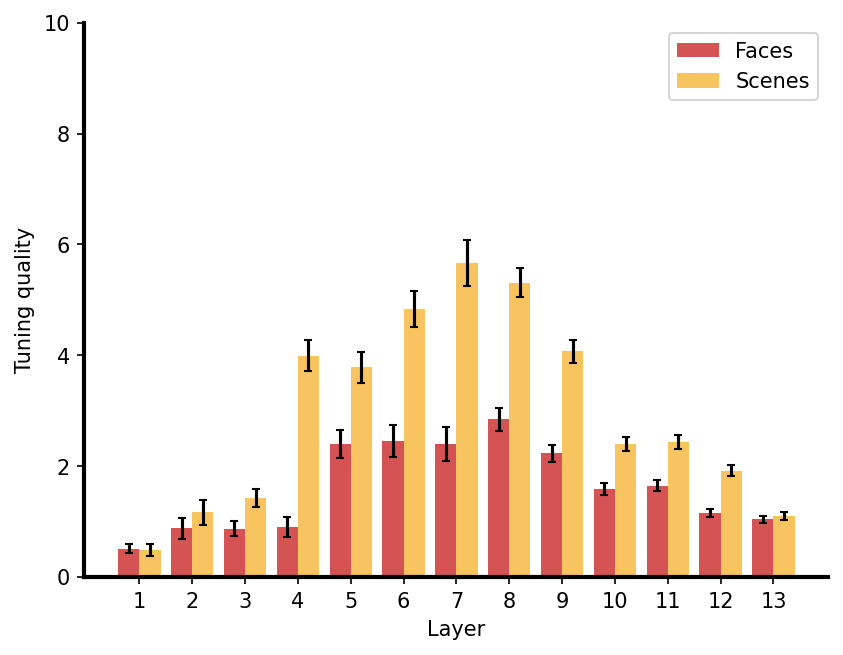

In [ ]:
plt.rcParams['figure.dpi'] = 150
import scipy.stats as stats

m = np.empty([13])
n = np.empty([13])
merr = np.empty([13])
nerr = np.empty([13])

r1 = np.arange(13)
barW = 0.4
r2 = [x + barW for x in r1]

for l in range(13):
  m[l] = np.mean(tun_q_face[l])
  merr[l] = stats.sem(tun_q_face[l])
  n[l] = np.mean(tun_q_scene[l])
  nerr[l] = stats.sem(tun_q_scene[l])

ax = plt.subplot(111)


ax.bar(r1,m,width = barW,label='Faces',yerr = merr,capsize=2,color = '#D65353')
ax.bar(r2,n,width = barW,label='Scenes',yerr = nerr,capsize=2,color = '#F7C45F')
plt.xticks([r + barW/2 for r in range(13)], np.arange(1,14))
plt.legend()
plt.ylabel('Tuning quality')
plt.xlabel('Layer')
ax.set_ylim(0,10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

plt.savefig('imtrain_tun_q.png')  # saves the current figure
plt.savefig('imtrain_tun_q.jpeg')  # saves the current figure

Text(0.5, 1.0, 'Number of face selective neurons')

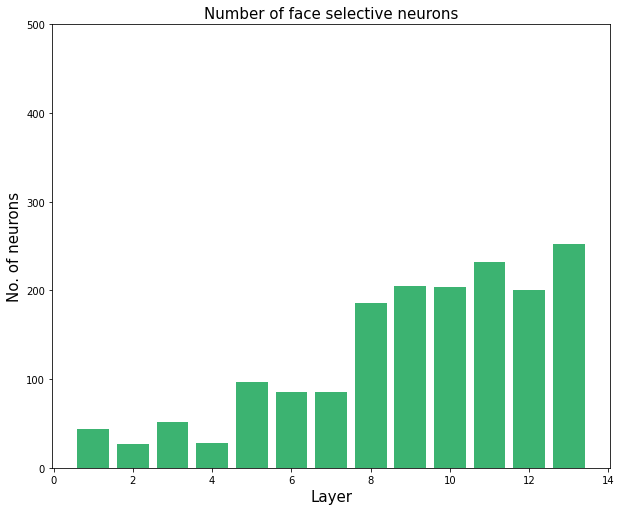

In [ ]:
idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

counter = np.zeros(13)
fig = plt.figure(figsize = (10,8))
for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      counter[layer] += 1
plt.bar(x = np.arange(1,14,1),
        height = counter,
        color = 'mediumseagreen')
plt.ylim(0,500)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of neurons',size = 15)
plt.title('Number of face selective neurons',size = 15)

In [ ]:
width = 0.4
plt.rcParams['figure.dpi'] = 300

idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1
c_scene[2] = 76
total_units = np.array([64,64,128,128,256,256,256,512,512,512,512,512,512])
c_face_ratio = np.divide(c_face,total_units)
c_scene_ratio = np.divide(c_scene,total_units)



fig, ax = plt.subplots(figsize = (10,8))
rects1 = ax.bar(np.arange(13), c_face_ratio, label='Faces',color = '#D65353')

rects2 = ax.bar(np.arange(13), c_scene_ratio, label='Scenes',color = '#F7C45F',bottom = c_face_ratio)

counter = 0
data = c_face
for bar in ax.patches:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_y() - 0.1,
      round(data[counter]),
      ha='center',
      color='w',
      weight='regular',
      size=12
  )
  counter = counter + 1
  if counter > 12:
    counter = 0
    data = c_scene


ax.axhline(y = 0.5,color = [0.3,0.3,0.3],linestyle = '--')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend(loc = 7,bbox_to_anchor=(1.1, 1.1))

plt.ylim(0,1.05)
plt.yticks([0,0.2,0.4,0.6,0.8,1],['0','0.2','0.4','0.6','0.8','1'],size = 20)
plt.xticks(np.arange(13),np.arange(1,14),size = 20)
plt.xlabel('Layer',size = 15)
plt.ylabel('Proportion of Maps',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
plt.savefig('imtrain_count.png')  # saves the current figure
plt.savefig('imtrain_count.jpeg')  # saves the current figure

#Gradient Calculations

In [ ]:
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
top_model.add(Dense(4, activation='softmax',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

g_labels_train = to_categorical(labels)
g_labels_test = to_categorical([0]* 40 + [1]*40 + [2]*40 + [3]*40)
g_train = np.vstack((reg_train[0],reg_train[1],reg_train[2],reg_train[3]))
g_test = np.vstack((reg_test[0],reg_test[1],reg_test[2],reg_test[3]))

G_train = model.predict(g_train)
G_test = model.predict(g_test)

history = top_model.fit(x = G_train,  y = g_labels_train,
            epochs=epochs,
            batch_size=64,
            verbose = 1, callbacks = [es])

out = top_model.evaluate(G_test, g_labels_test)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
5/5 [==============================] - 0s 4ms/step - loss: 0.7634 - accuracy: 0.7312


In [ ]:
calc_gradient_val = 1
if calc_gradient_val:
  layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
  cat_grads = [[[] for j in range(len(layer_names))] for i in range(ncats)]


  start = time.time()
  for i in range(ncats):
    idx = list(np.where(labels == i))
    cat_grads[i] = gc.calc_avg_gradcam(data_train[i],model,top_model)
  print(f'Elapsed: {time.time() - start}s')

  with open('gradient_values_cat', 'wb') as fp:
      pickle.dump(cat_grads, fp)

In [ ]:
corr_all_2 = st.calc_all_corrcoeff(fc[0:2],cat_grads[0:2])
corr_all_1 = st.calc_all_corrcoeff(fc[2:4],cat_grads[2:4])

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
import random

cat_grad_s = cat_grads.copy()
random.shuffle(cat_grad_s)

for cat in range(len(cat_grad_s)):
  for layer in range(len(cat_grad_s[cat])):
    random.shuffle(cat_grad_s[cat][layer])

corr_shuff = st.calc_all_corrcoeff(fc,cat_grad_s)
pt.plot_corr(corr_all_1,corr_shuff,figsize = (20,8))

# RDM Computations


In [35]:
#@title Tuning activ with attention

from contextlib import contextmanager
import sys, os
from vgg16obj.tools.model_calcs import gen_attnmap
import keras
from keras.utils import custom_object_scope, get_custom_objects
from keras.layers import Activation
from tensorflow.python.ops import nn


@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

def calc_tuningrange(model,data):
  ncats = 4
  t_ranges = [[np.empty((64)),
                np.empty((64)),
                np.empty((128)),
                np.empty((128)),
                np.empty((256)),
                np.empty((256)),
                np.empty((256)),
                np.empty((512)),
                np.empty((512)),
                np.empty((512)),
                np.empty((512)),
                np.empty((512)),
                np.empty((512))] for i in range(4*len(data[0]))]

  it = 0
  for cat in range(len(categories)):

    print(['Category of interest: ' +  str(cat)])

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    for imgs,img_tensor in enumerate(data[cat]):
      #if cat == 0 or cat == 1:
        #img_tensor = rm_white(img_tensor)
      img_tensor = img_tensor.reshape([1,224,224,3])
      intermediate_activations = activation_model.predict(img_tensor,verbose = 0)
      for l in range(len(layer_names)):
        layer_activation = intermediate_activations[l]
        #tun_activ[imgs][l] = layer_activation[0]
        t_ranges[it][l] = np.mean(layer_activation[0],axis = (0,1))
      it +=1
      del intermediate_activations #important to clear memory
  return t_ranges


def attn_properties(data,
                 modifier,
                 model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1):


    n_layers = 13
    categories = ["Males","Females","Manmades","Naturals"]
    for li in range(n_layers):
      print('Layer of interest: ', li)
      layermask = np.zeros(n_layers)
      layermask[li] = 1
      tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype)

      @keras.utils.register_keras_serializable(package="my_package", name="attnrelu")
      def attnrelu(x,map = tensor_attnmap,atype = atype):
          layeridx = np.load(idxpath)
          if layeridx == 13:
              layeridx = 0
          if atype == 1:
            x = nn.relu(x)
            activations = math.multiply(x,map[layeridx])
          if atype == 2:
            activations = math.add(x,map[layeridx])
            activations = nn.relu(activations)
          layeridx += 1
          np.save(idxpath,layeridx)
          return activations

      get_custom_objects().update({'attnrelu': Activation(attnrelu)})
      with custom_object_scope({'attnrelu': attnrelu}):

        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu

        del tensor_attnmap
        #utils.apply_modifications(model)

        model_tq = calc_tuningrange(model,data)
        with open('/content/drive/MyDrive/objfiles/RDMdata/vggfaceattn_trange_layer_'+
                str(li) + '_cat_' + str(cat) + '_strng_' + str(atstrng), 'wb') as fp:
          pickle.dump(model_tq, fp)

    del model



In [41]:
import gc
from multiprocessing import Process, Queue
layeridx = 0
np.save('layeridx',layeridx)
ncats = 4

for atstrng in np.arange(9,10): #Calling for different attn strengths

  for cat in [0,1]: # Iterating over 4 categories
    #print('Category of interest: ', categories[cat])

    attn_properties(reg_train,
                              fc,
                              model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1)

    gc.collect()

Layer of interest:  0
['Category of interest: 0']
['Category of interest: 1']
['Category of interest: 2']
['Category of interest: 3']
Layer of interest:  1
['Category of interest: 0']
['Category of interest: 1']
['Category of interest: 2']
['Category of interest: 3']
Layer of interest:  2
['Category of interest: 0']
['Category of interest: 1']
['Category of interest: 2']
['Category of interest: 3']
Layer of interest:  3
['Category of interest: 0']
['Category of interest: 1']
['Category of interest: 2']
['Category of interest: 3']
Layer of interest:  4
['Category of interest: 0']
['Category of interest: 1']
['Category of interest: 2']
['Category of interest: 3']
Layer of interest:  5
['Category of interest: 0']
['Category of interest: 1']
['Category of interest: 2']
['Category of interest: 3']
Layer of interest:  6
['Category of interest: 0']
['Category of interest: 1']
['Category of interest: 2']
['Category of interest: 3']
Layer of interest:  7
['Category of interest: 0']
['Category o

## Pre-computations and loading data

In [ ]:
# this is starter code. Run this only for independent rdms
ni = 320
from scipy.stats import pearsonr,spearmanr
from tensorflow_probability.python.stats import correlation

temp_rdm = np.empty((13,ni,ni))

for l in range(13):
  tempA = np.array([t_ranges[i][0] for i in range(ni)])
  tempB = np.array([t_ranges[i][0] for i in range(ni)])
  temp_rdm[l] = 1 - correlation(tempA.T,tempB.T)
  print(l)
#np.save('/content/drive/MyDrive/imtrain_rdm.npy',temp_rdm)


In [17]:
tq = []

load = '/content/drive/MyDrive/objfiles/RDMdata/vggfaceattn_trange_layer_' + str(2) + '_cat_'+str(0) #+ '_strng_9'

with open(load, 'rb') as fp:
  tq.extend(pickle.load(fp))

In [92]:
temp_rdm = np.empty((13,ni,ni))

for l in range(13):
  tempA = np.array([tq[i][l] for i in range(ni)])
  tempB = np.array([tq[i][l] for i in range(ni)])
  res = spearmanr(tempA,tempB,axis = 1)
  temp_rdm[l] = 1 - res.statistic

ValueError: could not broadcast input array from shape (640,640) into shape (320,320)

In [21]:
A = [[1,2,3],
     [4,5,6]]
B = [[7,8,9],
     [10,11,12]]
res = correlation(A,B)
print(res)

InvalidArgumentError: Value for attr 'T' of int32 is not in the list of allowed values: bfloat16, half, float, double, complex64, complex128
	; NodeDef: {{node Sqrt}}; Op<name=Sqrt; signature=x:T -> y:T; attr=T:type,allowed=[DT_BFLOAT16, DT_HALF, DT_FLOAT, DT_DOUBLE, DT_COMPLEX64, DT_COMPLEX128]> [Op:Sqrt] name: 

In [7]:
#@title RSA Helper Functions
plt.rcParams['figure.dpi'] = 72
ni = 320
from numpy.linalg import norm
from scipy.stats import spearmanr, kendalltau

from tensorflow_probability.python.stats import correlation
import tensorflow_probability.python as tfp
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV
from scipy import stats
from scipy.stats import pearsonr,spearmanr


def get_rdm(li,cat,type):
  tq = []
  if type:
    load = '/content/drive/MyDrive/objfiles/RDMdata/vggfaceattn_trange_layer_' + str(li) + '_cat_'+str(cat) #+ '_strng_9'
  else:
    load = '/content/drive/MyDrive/objfiles/RDMdata/imnetattn_trange_layer_'+ str(li) + '_cat_'+str(cat)

  with open(load, 'rb') as fp:
    tq.extend(pickle.load(fp))
  ni = 320

  temp_rdm = np.empty((13,ni,ni))

  for l in range(13):
    tempA = np.array([tq[i][l] for i in range(ni)])
    tempB = np.array([tq[i][l] for i in range(ni)])
    temp_rdm[l] = 1 - correlation(tempA.T,tempB.T)
  if type:
    np.save('/content/drive/MyDrive/objfiles/RDMdata/RDMs/RDM_vggface_layer_' + str(li) + '_cat_'+str(cat),temp_rdm)
  else:
    np.save('/content/drive/MyDrive/objfiles/RDMdata/RDMs/RDM_imnet_layer_' + str(li) + '_cat_'+str(cat),temp_rdm)

  return temp_rdm

def digitize_rdm(rdm_raw, n_bins = 10):

    rdm_bins = [np.percentile(np.ravel(rdm_raw), 100/n_bins * i) for i in range(n_bins)]
    rdm_vec_digitized = np.digitize(np.ravel(rdm_raw), bins = rdm_bins) * (100 // n_bins)
    rdm_digitized = np.reshape(rdm_vec_digitized, np.shape(rdm_raw))
    rdm_digitized = (rdm_digitized + rdm_digitized.T) / 2

    return rdm_digitized

def plot_rdm(rdm_data):
  layer_show = iter([1,4,8,11])
  fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(3.5, 12))
  for row in axes:

    l = next(layer_show)
    rdm_digitized = digitize_rdm(rdm_data[l])
    im = row.imshow(rdm_digitized)
    row.set_yticks([0,ni*0.25,ni*0.5])
    row.set_yticklabels(['','',''])
    row.set_xticks([0,ni*0.25,ni*0.5])
    row.set_xticklabels(['','',''])
    row.set_title(str(l + 1),fontsize = 12,fontweight = 'semibold',alpha = 0.5)


def vectorize(data):
  y = np.empty(())
  start = 0
  for i in range(len(data)):
    temp = data[start,start:len(data)]
    y = np.append(y,temp)
    start += 1
  return y

def split_r(model,b,imgs,ratio):
  la = len(model)
  niter = 5
  corr = np.empty((13,niter))
  p = 1 #Null is true


  for iter in range(niter):
    select_imgs = np.random.choice(la,int(la*ratio),replace = True)

    #Check if images to be tested are faces or scenes
    for l in range(13):
      if imgs == 'f':
        b_v = b[l,0:160,0:160]
      elif imgs == 's':
        b_v = b[l,160:320,160:320]
      else:
        b_v = b[l]

      a_rdm = np.empty((len(select_imgs),len(select_imgs)))
      b_rdm = np.empty((len(select_imgs),len(select_imgs)))

      for ii,i in enumerate(select_imgs):
        for jj,j in enumerate(select_imgs):
          a_rdm[ii,jj] = model[i,j]
          b_rdm[ii,jj] = b_v[i,j]

      n = len(select_imgs)
      a_rdm = np.ones((n,n))
      a_rdm[0:int(n/2),0:int(n/2)] = 0
      a_rdm[int(n/2):n,int(n/2):n] = 0
      corr[l,iter],_ = spearmanr(vectorize(a_rdm),vectorize(b_rdm))
  mcorr = np.mean(corr,axis = 1)
  stdcorr = stats.sem(corr,axis = 1)
  return mcorr,stdcorr,corr

def regress_RSA(X,rdm):
  reg = [[] for i in range(13)]

  for l in range(13):
    m = vectorize(rdm[l])

    reg[l] = RidgeCV(cv = 5,alphas = [1,10,100]).fit(X.T,m)

  return reg


  # plt.colorbar(im,ax = axes.ravel().tolist(),
  #              label="Dissimilarity [Percentile]", orientation="vertical",
  #              shrink=0.8)

# plot_rdm(imgnet_rdm[:,0:160,0:160]) #faces from imtrain model
# # plt.savefig('/content/plots/imtrain_faces_rdm.png',bbox_inches='tight')  # saves the current figure
# plot_rdm(imgnet_rdm[:,160:320,160:320]) #scenes from imtrain model
# # plt.savefig('/content/plots/imtrain_scenes_rdm.png',bbox_inches='tight')  # saves the current figure


# plot_rdm(face_rdm[:,0:160,0:160]) #faces from facetrain model
# # plt.savefig('/content/plots/vggface_faces_rdm.png',bbox_inches='tight')  # saves the current figure
# plot_rdm(face_rdm[:,160:320,160:320]) #scenes from scenetrain model
# # plt.savefig('/content/plots/vggface_scenes_rdm.png',bbox_inches='tight')  # saves the current figure

# !zip -r plots.zip plots/

[Text(0.0, 0, ''), Text(80.0, 0, ''), Text(160.0, 0, '')]

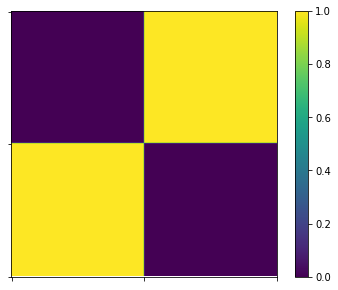

In [8]:
#@title Model RDM
model_rdm = np.ones((160,160))
model_rdm[0:80,0:80] = 0
model_rdm[0:80,80:160] = 1
model_rdm[80:160,80:160] = 0
model_rdm[80:160,0:80] = 1
#plt.imshow(model_rdm)
#plt.colorbar()

ni = 320
mod_rdm_a = np.ones((320,320))
mod_rdm_a[0:160,0:160] = 0
mod_rdm_a[160:320,160:320] = 0

#plt.imshow(mod_rdm_a)

mod_rdm_b = np.ones((320,320))
mod_rdm_b[0:80,0:80] = 0
mod_rdm_b[80:160,80:160] = 0
mod_rdm_b[160:240,160:240] = 0
mod_rdm_b[240:320,240:320] = 0

mod_rdm_c = np.ones((320,320))
mod_rdm_c[0:80,0:80] = 0
mod_rdm_c[80:160,80:160] = 0

mod_rdm_d = np.ones((320,320))
mod_rdm_d[160:240,160:240] = 0
mod_rdm_d[240:320,240:320] = 0

mod_rdm_e = np.ones((320,320))
mod_rdm_e[0:80,0:80] = 0
mod_rdm_e[80:160,80:160] = 0
mod_rdm_e[160:240,160:240] = 0
mod_rdm_e[240:320,240:320] = 0
mod_rdm_e[0:80,80:160] = 0.5
mod_rdm_e[80:160,0:80] = 0.5
mod_rdm_e[160:240,240:320] = 0.5
mod_rdm_e[240:320,160:240] = 0.5


fig,ax = plt.subplots()
plt.imshow(model_rdm)
plt.colorbar()
ax.set_yticks([0,ni*0.25,ni*0.5])
ax.set_yticklabels(['','',''])
ax.set_xticks([0,ni*0.25,ni*0.5])
ax.set_xticklabels(['','',''])

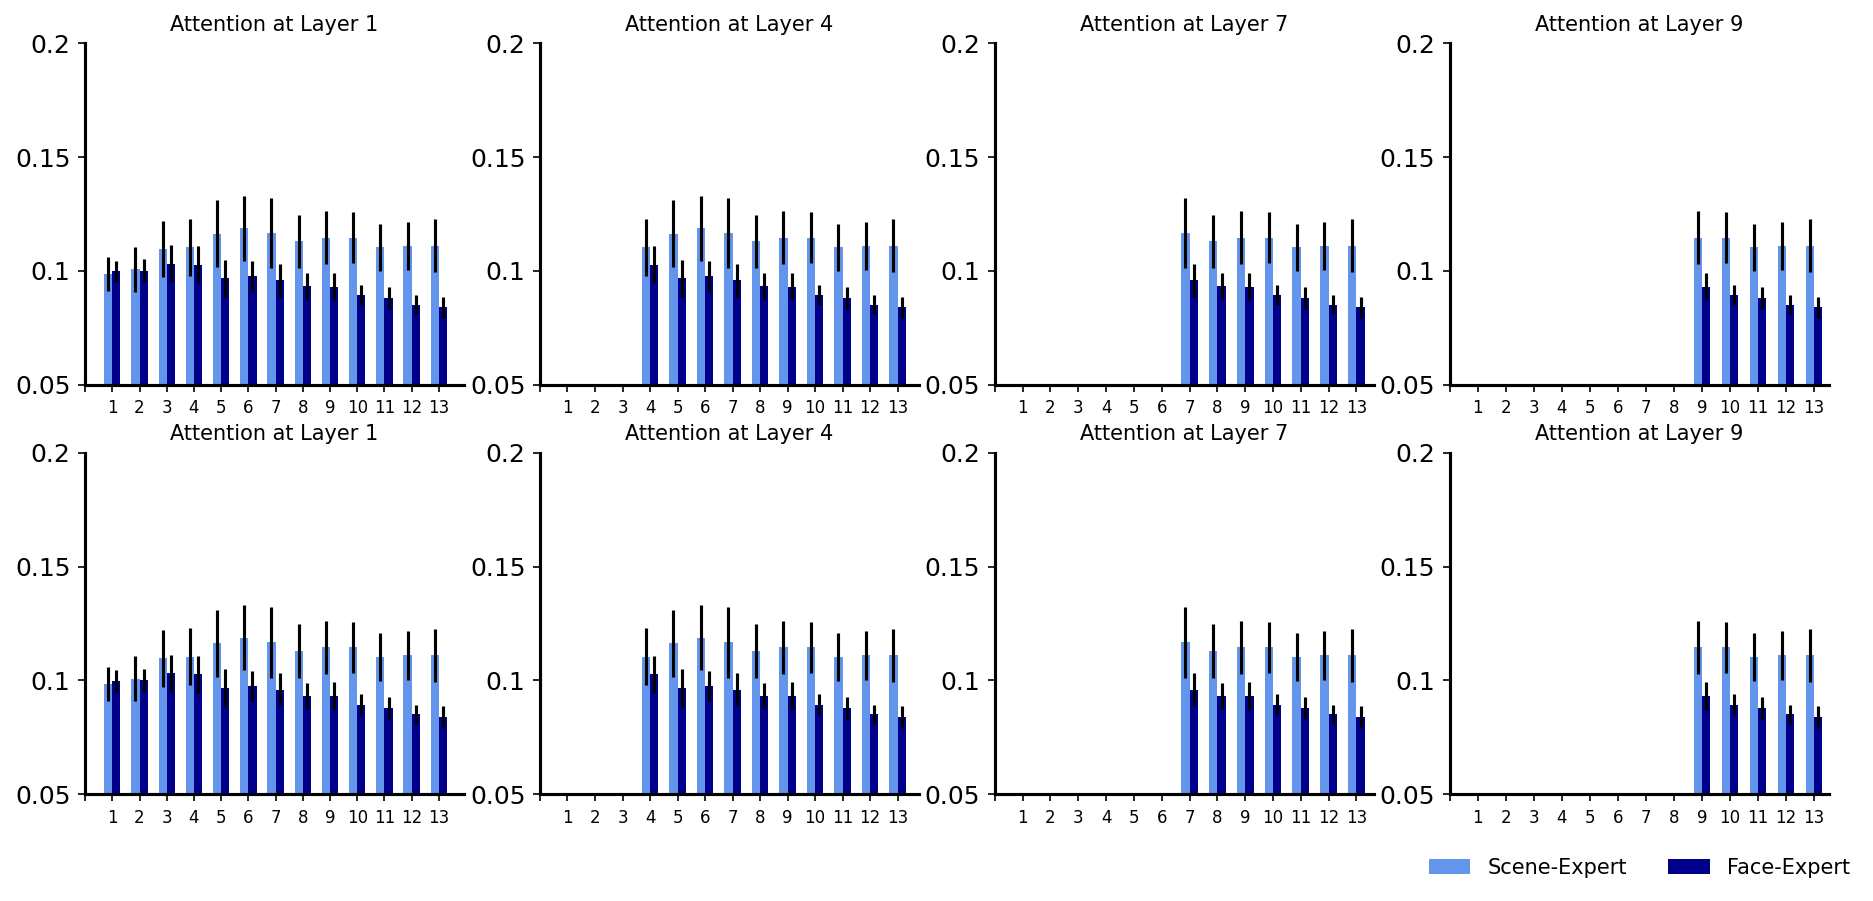

In [22]:
imgnet_rdm = np.load('/content/drive/MyDrive/placestrain_rdm.npy') #this is without attention
face_rdm = np.load('/content/drive/MyDrive/facetrain_rdm.npy') #this is without attention

import scipy
from statsmodels.sandbox.stats.multicomp import multipletests

np.set_printoptions(suppress=True)

barW = 0.3

li = -1
r1 = np.arange(1,14)
cats = iter(["Faces","Scenes"])


fig,ax = plt.subplots(nrows=2, ncols=4,figsize=(15,6.5),dpi = 150)
c = 0
for rows in ax:
  c += 1
  layerx = iter([0,3,6,8])
  for col in rows:
    li = next(layerx)
    # imgnet_rdm = get_rdm(li,c,False)
    # face_rdm = get_rdm(li,c,True)

    #sim_imtrain,error_imtrain,allsim_imtrain = split_r(mod_rdm_a,imgnet_rdm,'x',1)
    #sim_vggface,error_vggface,allsim_vggface = split_r(mod_rdm_a,face_rdm,'x',1)

    # p = np.empty((13,2))
    # for l in range(13):
    #     p[l,:] = scipy.stats.wilcoxon(allsim_imtrain[l],allsim_vggface[l],alternative = 'two-sided')
    # p_adjusted = multipletests(p[:,1], method='fdr_bh')
    # print(p_adjusted)

    col.bar(x = r1[li:13] -barW/2,width = barW,yerr = error_imtrain[li:13],height = sim_imtrain[li:13],
            color = 'cornflowerblue',label = 'Scene-Expert')
    col.bar(x = r1[li:13] + barW/2,width = barW,yerr = error_vggface[li:13],
            height = sim_vggface[li:13],color = 'darkblue',label = 'Face-Expert')

    col.set_title('Attention at Layer ' + str(li+1),fontsize = 10)
    col.set_xticks([r  for r in range(0,14)], [''] + [str(i) for i in range(1, 14)],fontsize = 8)

    col.spines['right'].set_visible(False)
    col.spines['top'].set_visible(False)
    col.spines['left'].set_linewidth(1.5)
    col.spines['bottom'].set_linewidth(1.5)
    col.set_ylim(0.005,0.02)
    col.set_yticks([0.005,0.01,0.015,0.02])
    col.set_yticklabels([0.05,0.1,0.15,0.2],fontsize = 12)

  plt.legend(fontsize = 10,ncol = 2,frameon = False,loc = 'lower center',bbox_to_anchor=(0.5, -0.3))

  #plt.savefig('/content/plots/faces_similarity-of-RDMs.png',bbox_inches='tight')  # saves the current figure
  #plt.savefig('/content/plots/faces_similarity-of-RDMs.jpeg',bbox_inches='tight')  # saves the current figure


  # ax = plt.subplot(122)

  # sim_imtrain,error_imtrain,allsim_imtrain = split_r(model_rdm,imgnet_rdm,'s',1)
  # sim_vggface,error_vggface,allsim_vggface = split_r(model_rdm,face_rdm,'s',1)

  # # p = np.empty((13,2))
  # # for l in range(13):
  # #     p[l,:] = scipy.stats.wilcoxon(allsim_imtrain[l],allsim_vggface[l],alternative = 'two-sided')
  # # p_adjusted = multipletests(p[:,1], method='fdr_bh')
  # # print(p_adjusted)

  # plt.bar(x = np.arange(1,14),width = barW,yerr = error_imtrain,height = sim_imtrain,
  #         color = 'cornflowerblue',label = 'Image-trained')
  # plt.bar(x = np.arange(1,14) + barW,width = barW,yerr = error_vggface,
  #         height = sim_vggface,color = 'darkblue',label = 'Face-trained')

  # plt.title('RSA for Scene images- Manmande & Natural')
  # ax.set_xticks(np.arange(1,14) + barW/2)
  # ax.set_xticklabels(np.arange(1,14).astype('str'),fontsize = 12)
  # ax.spines['right'].set_visible(False)
  # ax.spines['top'].set_visible(False)
  # ax.spines['left'].set_linewidth(2)
  # ax.spines['bottom'].set_linewidth(2)
  # #ax.set_ylim(0,0.55)
  # plt.legend()

  plt.savefig('/content/similarity-of-RDMs_wo_attn.png',bbox_inches='tight',dpi = 300)  # saves the current figure
  plt.savefig('/content/similarity-of-RDMs_wo_attn.jpeg',bbox_inches='tight',dpi = 300)  # saves the current figure


Text(0.5, 1.0, 'VGGFace trained model')

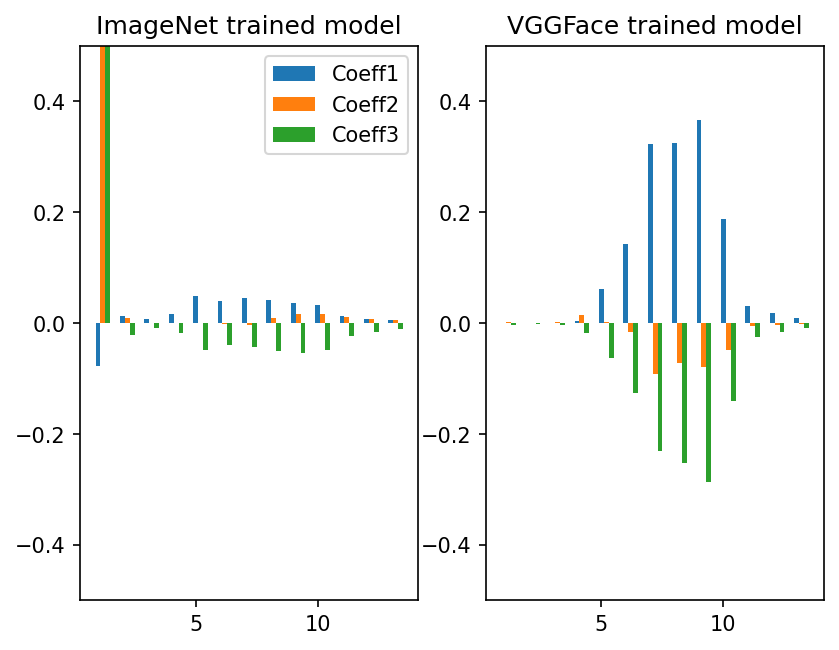

In [15]:
X = np.vstack((vectorize(mod_rdm_a),vectorize(mod_rdm_c),vectorize(mod_rdm_d)))

R = regress_RSA(X,imgnet_rdm)
coeff = np.empty((13,3))
for l in range(13):
  coeff[l,:] = R[l].coef_

ax = plt.subplot(121)
barW = 0.2
plt.bar(x = np.arange(1,14),width = barW,
        height = coeff[:,0],label = 'Coeff1')
plt.bar(x = np.arange(1,14) + barW,width = barW,
        height = coeff[:,1],label = 'Coeff2')
plt.bar(x = np.arange(1,14) + barW*2,width = barW,
        height = coeff[:,2],label = 'Coeff3')
# plt.bar(x = np.arange(1,14) + barW*3,width = barW,
#         height = coeff[:,3],label = 'Coeff4')
plt.legend()
plt.ylim(-0.5,0.5)
ax.set_title('ImageNet trained model')


R = regress_RSA(X,face_rdm)
coeff = np.empty((13,3))
for l in range(13):
  coeff[l,:] = R[l].coef_

ax = plt.subplot(122)
barW = 0.2
plt.bar(x = np.arange(1,14),width = barW,
        height = coeff[:,0],label = 'Coeff1')
plt.bar(x = np.arange(1,14) + barW,width = barW,
        height = coeff[:,1],label = 'Coeff2')
plt.bar(x = np.arange(1,14) + barW*2,width = barW,
        height = coeff[:,2],label = 'Coeff3')
# plt.bar(x = np.arange(1,14) + barW*3,width = barW,
#         height = coeff[:,3],label = 'Coeff4')
plt.ylim(-0.5,0.5)
ax.set_title('VGGFace trained model')

In [ ]:
import statsmodels.formula.api as smf
import pandas as pd
sim_imtrain,error_imtrain,allsim_imtrain = split_r(model_rdm,imgnet_rdm,'f',1)
sim_vggface,error_vggface,allsim_vggface = split_r(model_rdm,face_rdm,'f',1)
d = np.concatenate([sim_imtrain,sim_vggface])
data = {
    'RSM': d,
    'image': np.concatenate([['A']*13,['B']*13]),
    'layer': np.concatenate([range(1,14),range(1,14)])
}

df = pd.DataFrame(data)
model = smf.mixedlm("RSM ~image + C(layer)",df,groups = df.image)
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  RSM    
No. Observations:   26       Method:              REML   
No. Groups:         2        Scale:               0.0004 
Min. group size:    13       Log-Likelihood:      24.4101
Max. group size:    13       Converged:           Yes    
Mean group size:    13.0                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.079    0.025  3.182 0.001  0.030  0.128
image[T.B]      0.014    0.030  0.481 0.631 -0.044  0.072
C(layer)[T.2]   0.014    0.020  0.690 0.490 -0.026  0.053
C(layer)[T.3]   0.003    0.020  0.137 0.891 -0.037  0.042
C(layer)[T.4]  -0.009    0.020 -0.447 0.655 -0.048  0.030
C(layer)[T.5]  -0.014    0.020 -0.685 0.494 -0.053  0.026
C(layer)[T.6]  -0.012    0.020 -0.577 0.564 -0.051  0.028
C(layer)[T.7]  -0.009   

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
sm.qqplot(result.resid)

In [ ]:
#sim_imtrain,error_imtrain,allsim_imtrain = split_r(model_rdm,scene_rdm,'s',1)
#sim_vggface,error_vggface,allsim_vggface = split_r(model_rdm,face_rdm,'s',1)
#d = np.concatenate([d,sim_imtrain,sim_vggface])
data2 = {
    'RSM': d,
    'image': np.concatenate([['A']*13,['B']*13,['C']*13,['D']*13]),
    'layer': np.concatenate([range(1,14),range(1,14),range(1,14),range(1,14)]),
    'model': np.concatenate([[1]*26,[2]*26])
}
df = pd.DataFrame(data2)
model = smf.mixedlm("RSM ~ image + C(layer)",df,groups = df.model)
result = model.fit()
print(result.summary())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: RSM    
No. Observations:   52      Method:             REML   
No. Groups:         2       Scale:              0.0029 
Min. group size:    26      Log-Likelihood:     41.8838
Max. group size:    26      Converged:          Yes    
Mean group size:    26.0                               
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      0.016    0.062 0.258 0.797 -0.105  0.137
image[T.B]     0.014    0.021 0.671 0.502 -0.027  0.056
image[T.C]     0.144    0.079 1.814 0.070 -0.012  0.299
image[T.D]     0.057    0.079 0.723 0.470 -0.098  0.212
C(layer)[T.2]  0.007    0.038 0.191 0.848 -0.067  0.082
C(layer)[T.3]  0.014    0.038 0.362 0.717 -0.061  0.089
C(layer)[T.4]  0.018    0.038 0.463 0.643 -0.057  0.092
C(layer)[T.5]  0.047    0.038 1.242 0.214 -0.027  0.122
C

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
!zip -r plots.zip /content/drive/MyDrive/objfiles/plots

  adding: content/drive/MyDrive/objfiles/plots/ (stored 0%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs_0.png (deflated 34%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs0.jpeg (deflated 56%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs_1.png (deflated 34%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs1.jpeg (deflated 56%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs_2.png (deflated 34%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs2.jpeg (deflated 56%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs_3.png (deflated 34%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs3.jpeg (deflated 56%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs_4.png (deflated 34%)
  adding: content/drive/MyDrive/objfiles/plots/scenes_similarity-of-RDMs4.jpeg (deflated 57%)


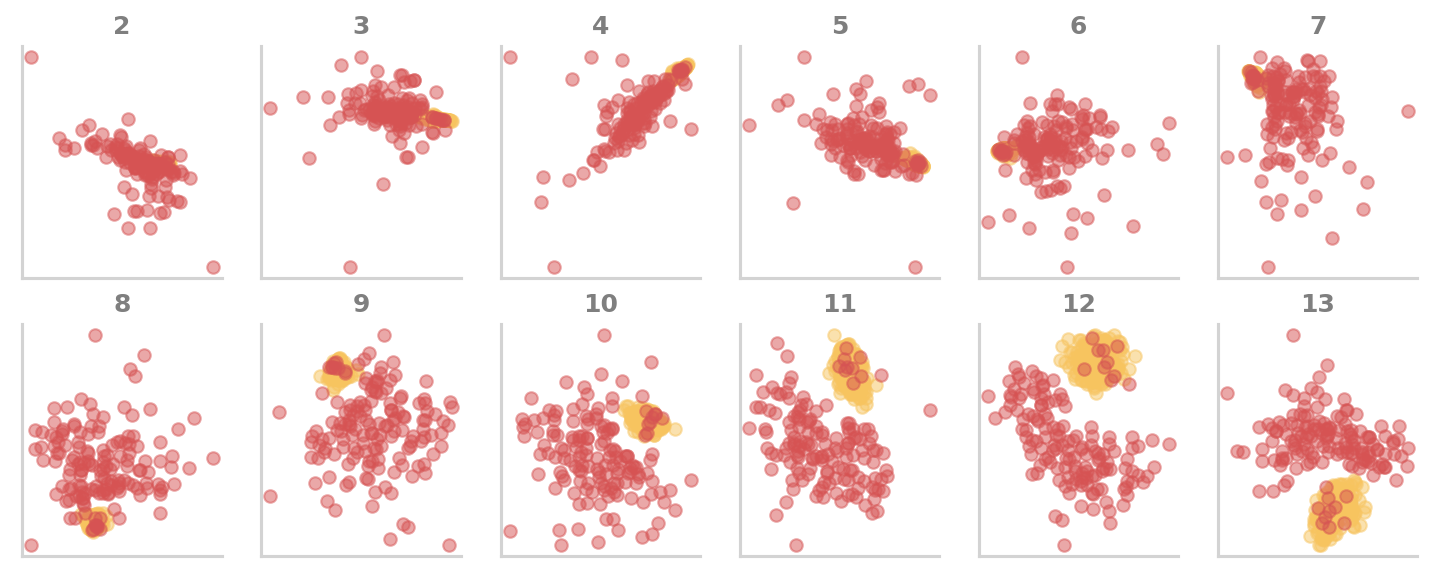

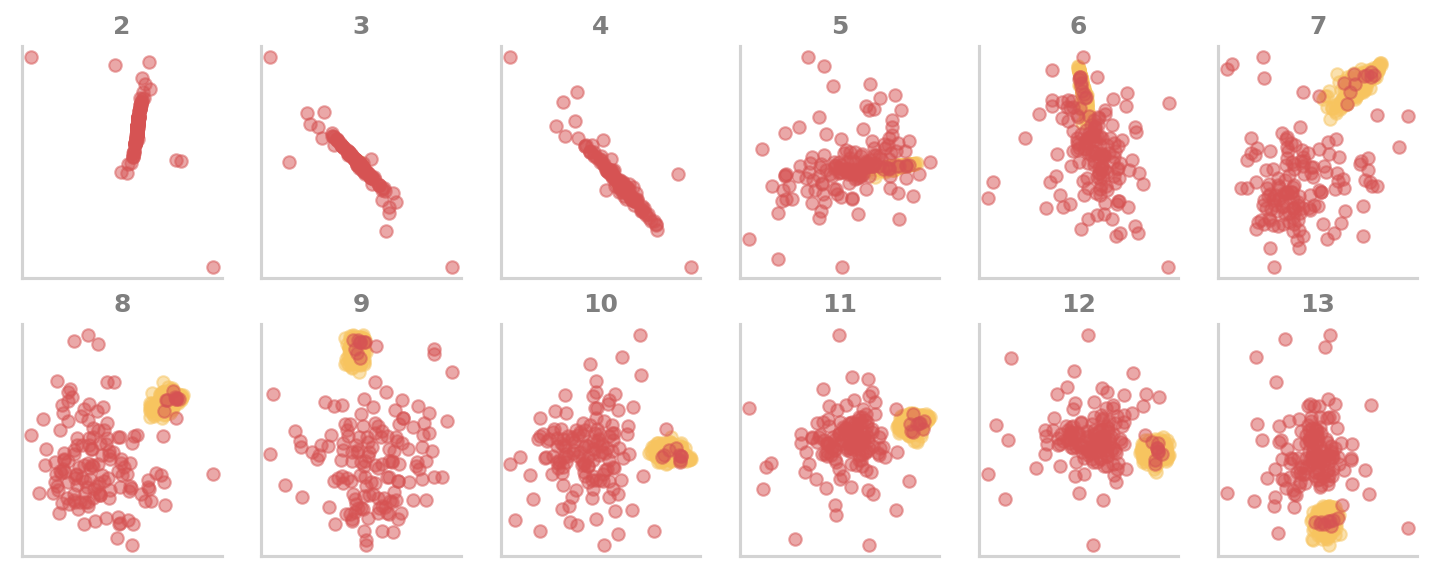

In [ ]:
from sklearn.manifold import MDS

def compute_mds(data):
  out = np.empty((13,300,2))
  mds = MDS(dissimilarity='precomputed', n_components=2)
  for l in range(13):
    out[l] = mds.fit_transform(data[l])
  return out

plt.rcParams['figure.dpi'] = 150

def plot_mds(data):
  layer_show = iter([1,2,3,4,5,6,7,8,9,10,11,12,13])
  fig, ax = plt.subplots(nrows=2, ncols=6,figsize=(12, 4.5))
  for row in ax:
    for col in row:
      l = next(layer_show)
      col.scatter(data[l,0:150, 0], data[l,0:150, 1],c = "#F7C45F",alpha = 0.5,marker = 'o') #red
      col.scatter(data[l,150:300, 0], data[l,150:300, 1],c = "#D65353",alpha = 0.5,marker = 'o') #yellow
      col.set_title(str(l + 1),fontsize = 12,fontweight = 'semibold',alpha = 0.5)

      col.set_xticks([])
      col.set_yticks([])
      col.set_xticks([], minor=True)
      col.set_yticks([], minor=True)
      col.spines['right'].set_visible(False)
      col.spines['top'].set_visible(False)
      col.tick_params(axis = 'both',labelsize=10)

      for axis in ['top','bottom','left','right']:
        col.spines[axis].set_linewidth(1.5)
        col.spines[axis].set_color('lightgray')


#only compute once, takes long to run
#s_mds = compute_mds(imgnet_rdm)
#f_mds = compute_mds(face_rdm)

plot_mds(s_mds)
#plt.savefig('/content/plots/imtrain_mds.png',bbox_inches='tight')  # saves the current figure
#plt.savefig('/content/plots/imtrain_mds.jpeg',bbox_inches='tight')  # saves the current figure
plot_mds(f_mds)
#plt.savefig('/content/plots/facetrain_mds.png',bbox_inches='tight')  # saves the current figure
#plt.savefig('/content/plots/facetrain_rdm.jpeg',bbox_inches='tight')  # saves the current figure


## MDS of RDMs

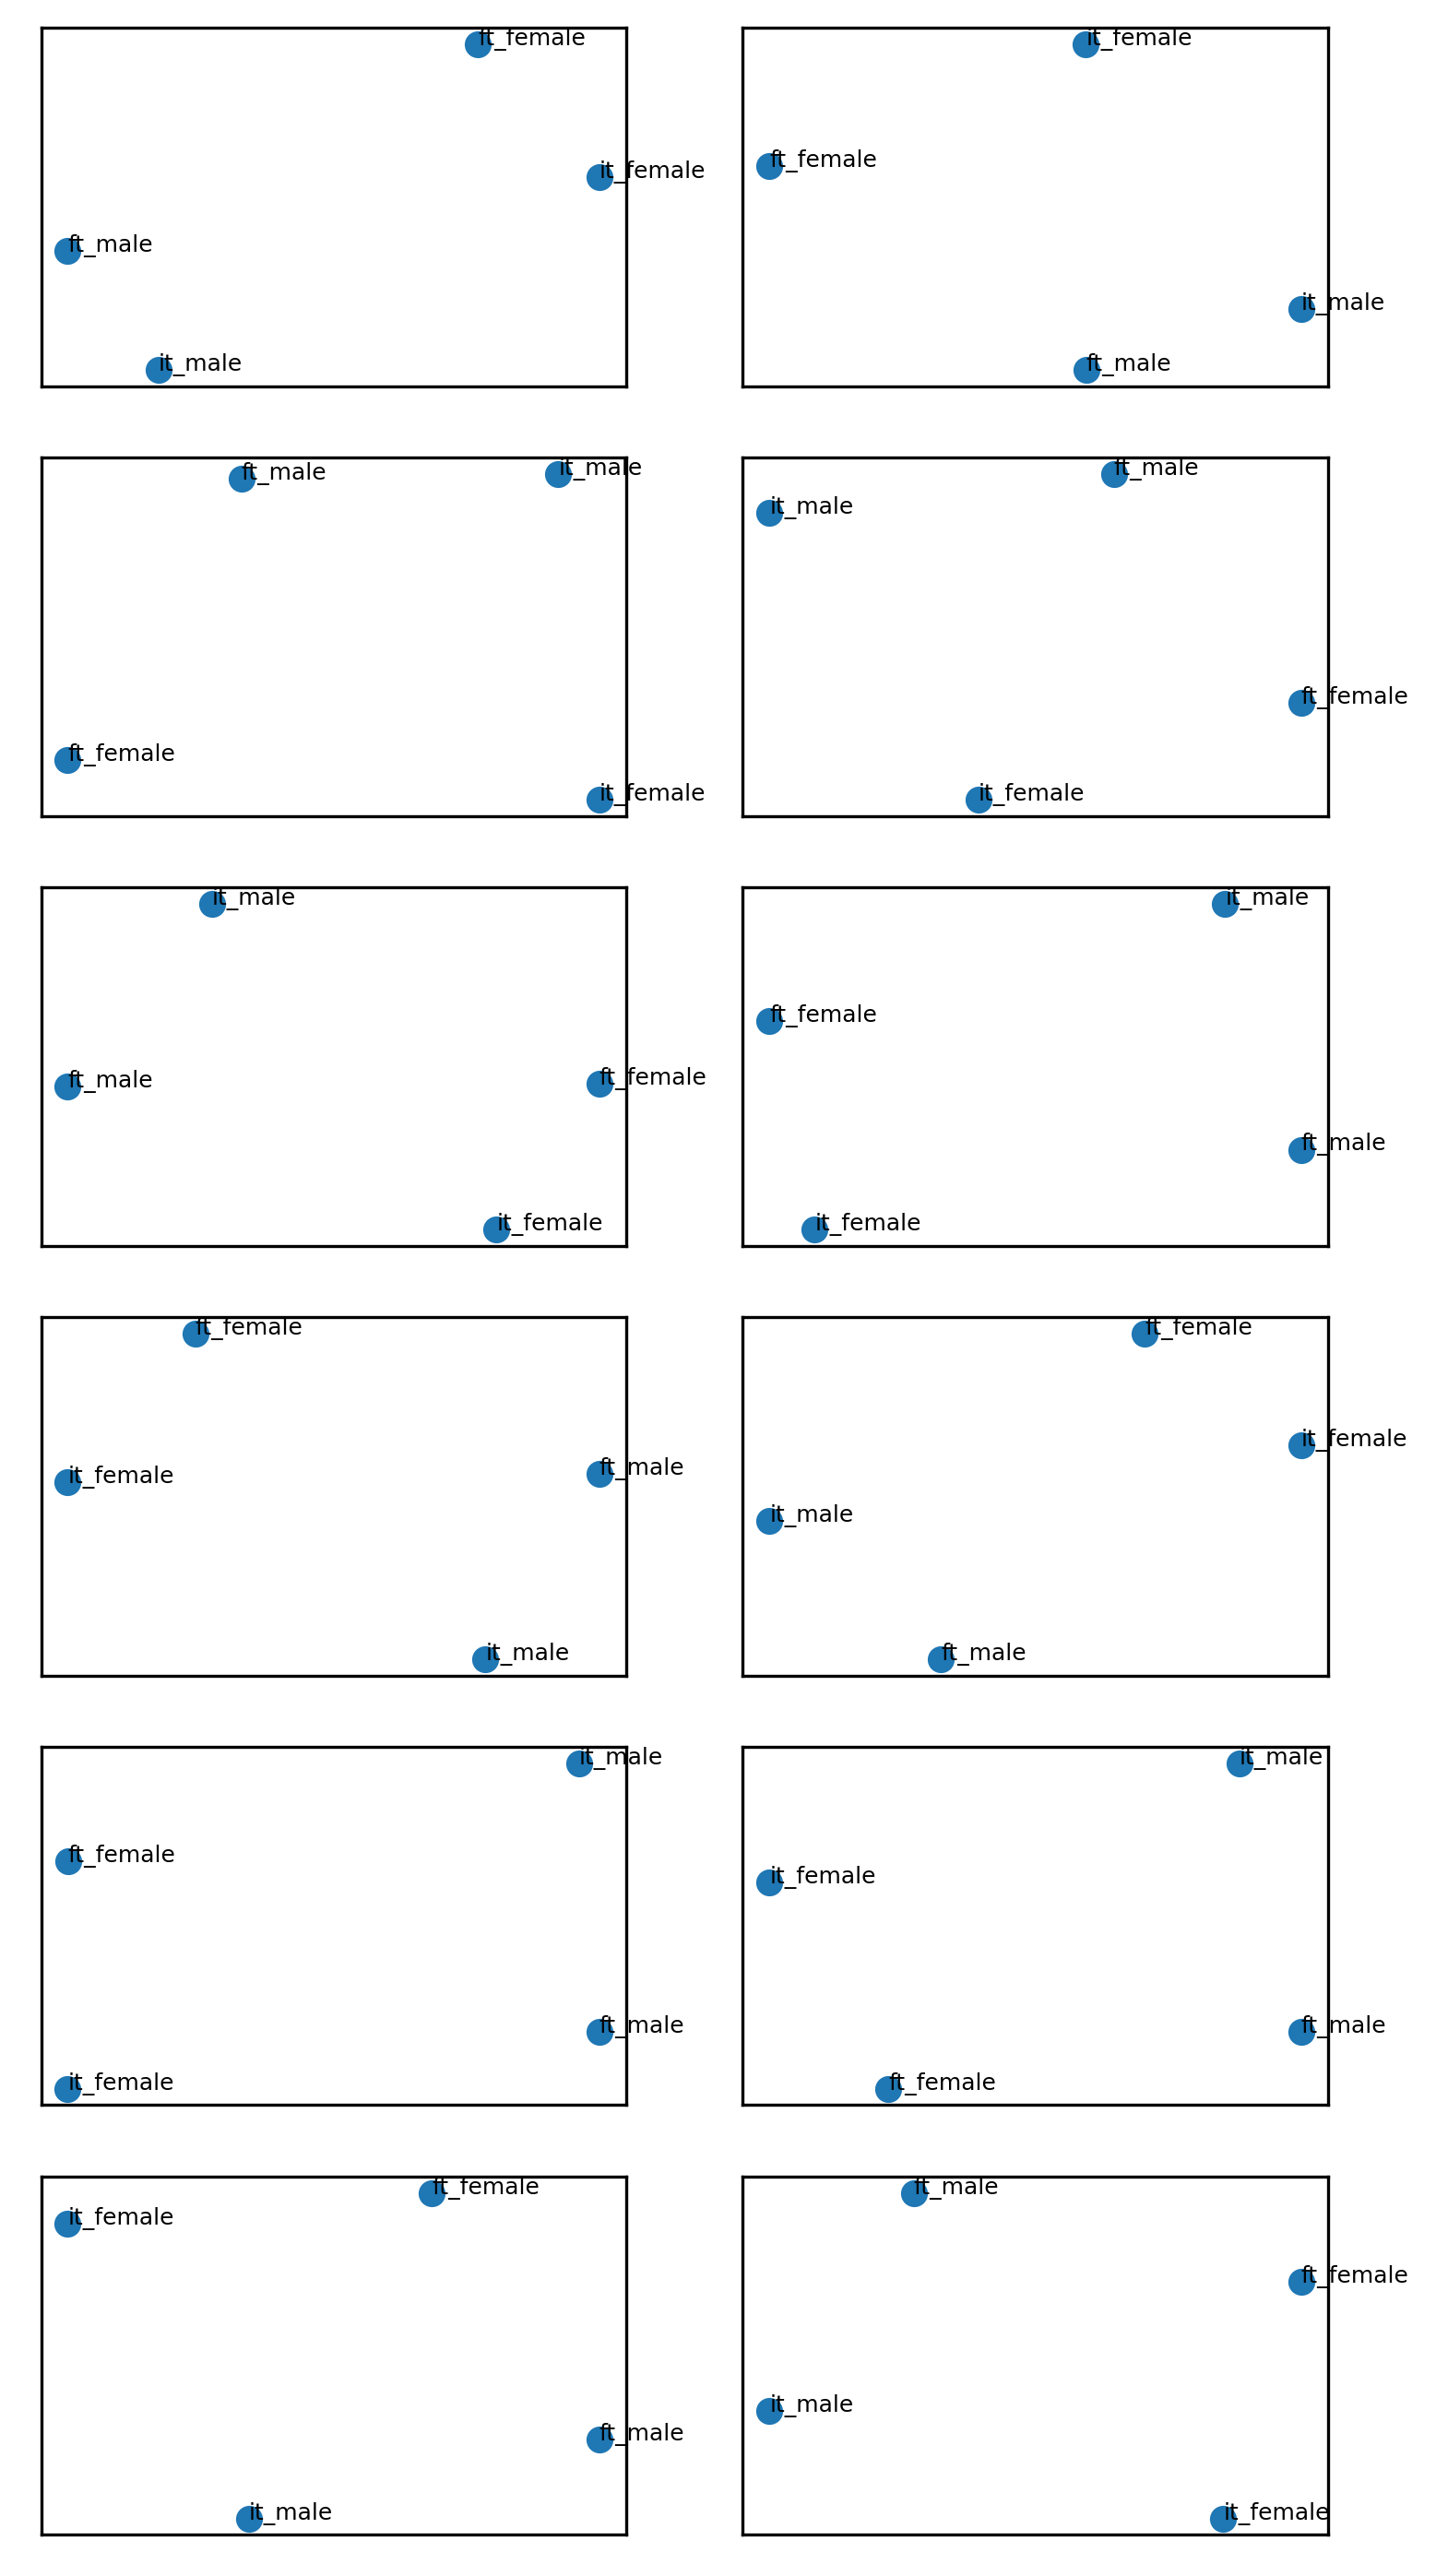

In [ ]:
from sklearn.manifold import MDS
mds = MDS(dissimilarity='precomputed', n_components=2)
plt.rcParams['figure.dpi'] = 300

layer_show = iter([1,2,3,4,5,6,7,8,9,10,11,12,13])

fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(6, 12))
for row in ax:
  for col in row:
    l = next(layer_show)
    imt_face_male = vectorize(imgnet_rdm[l,0:75,0:75])
    imt_face_female = vectorize(imgnet_rdm[l,75:150,75:150])

    imt_scene_man = vectorize(imgnet_rdm[l,150:225,150:225])
    imt_scene_nat = vectorize(imgnet_rdm[l,225:300,225:300])

    ft_face_male = vectorize(face_rdm[l,0:75,0:75])
    ft_face_female = vectorize(face_rdm[l,75:150,75:150])

    ft_scene_man = vectorize(face_rdm[l,150:225,150:225])
    ft_scene_nat = vectorize(face_rdm[l,225:300,225:300])

    allrdms = np.stack((imt_face_male,imt_face_female,ft_face_male,ft_face_female),axis = 0)
    corr_rdms,_ = spearmanr(allrdms, axis = 1)
    corr_rdms = 1 - corr_rdms
    allmds = mds.fit_transform(corr_rdms)
    col.scatter(allmds[:,0],allmds[:,1])
    col.text(allmds[0,0],allmds[0,1],'it_male',fontsize = 6)
    col.text(allmds[1,0],allmds[1,1],'it_female',fontsize = 6)
    col.text(allmds[2,0],allmds[2,1],'ft_male',fontsize = 6)
    col.text(allmds[3,0],allmds[3,1],'ft_female',fontsize = 6)
    col.set_xticks([])
    col.set_yticks([])
    col.set_xticks([], minor=False)
    col.set_yticks([], minor=False)

# Neuron level activities

### Calculate the tuning range of each neuron by computing its histogram of activity across all images.

In [ ]:
calc_neuron_activ = 1
ncats = 4
t_ranges = np.empty([ncats,len(reg_train),13])

def rm_white(reg):
  r = np.random.uniform(0,1)
  for row in range(len(reg)):
    for col in range(len(reg[row])):
      for chan in range(len(reg[row,col])):
        if reg[row,col,chan] == 1:
          reg[row,col,chan] = np.random.uniform(0,1)
  return reg

if calc_neuron_activ:
  for cat in range(len(categories)):

    print('Category of interest: ', categories[cat])
    train_it = reg_train[cat]

    layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]
    layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    tun_activ = [[np.empty((224,224,64)),
              np.empty((224,224,64)),
              np.empty((112,112,128)),
              np.empty((112,112,128)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((56,56,256)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((28,28,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512)),
              np.empty((14,14,512))] for i in range(len(train_it))]


    start = time.time()
    for imgs,img_tensor in enumerate(train_it):
      #if cat == 0 or cat == 1:
        #img_tensor = rm_white(img_tensor)
      img_tensor = img_tensor.reshape([1,224,224,3])
      intermediate_activations = activation_model.predict(img_tensor,verbose = 0)
      for l in range(len(layer_names)):
        layer_activation = intermediate_activations[l]
        #tun_activ[imgs][l] = layer_activation[0]
        t_ranges[cat][imgs][l] = np.mean(layer_activation[0])
      del intermediate_activations #important to clear memory

  print(f'Elapsed: {time.time() - start}s')

Category of interest:  Male


IndexError: ignored

In [ ]:
def my_norm(a):
  ratio = 2/(np.max(a)-np.min(a))
  shift = (np.max(a)+np.min(a))/2
  return (a - shift)*ratio

def plot_tuning_range(a,b,a_col,b_col):
  layer_show = iter([4,7,9,12])
  fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8, 8))
  for row in ax:
    for col in row:
      l = next(layer_show)
      sns.kdeplot(np.array(my_norm(a[:,l])),bw = 0.5,ax = col,color = a_col,linewidth = 5,shade = True)
      sns.kdeplot(np.array(my_norm(b[:,l])),bw = 0.5,ax = col,color = b_col,linewidth = 5,shade = True)
      col.set_ylim(0,1.5)
      col.set_yticks([0,0.50,1,1.5])
      col.set_ylabel('')
      col.text(0.92, 0.9, str(l + 1), horizontalalignment='center',
              verticalalignment='center', transform=col.transAxes,
              color = 'gray',fontweight = 'semibold',fontsize = 18)
      col.spines['right'].set_visible(False)
      col.spines['top'].set_visible(False)
      col.spines['left'].set_linewidth(3)
      col.spines['bottom'].set_linewidth(3)
      col.tick_params(axis = 'both',labelsize=10)
      col.colorbar
plt.rcParams['figure.dpi'] = 300

face_range = np.concatenate((t_ranges[0,:,:],t_ranges[1,:,:]),axis = 0)
scene_range = np.concatenate((t_ranges[2,:,:],t_ranges[3,:,:]),axis = 0)
face1_range = t_ranges[0]
face2_range = t_ranges[1]
scene1_range = t_ranges[2]
scene2_range = t_ranges[3]


plot_tuning_range(scene1_range,scene2_range,'#f5c15b','#b89d25')
plt.savefig('/content/imtrain_suppl/imtrain_scene_tun_r.png')  # saves the current figure
plt.savefig('/content/imtrain_suppl/imtrain_scene_tun_r.jpeg')  # saves the current figure

plot_tuning_range(face1_range,face2_range,'#f57f7f','#991717')
plt.savefig('/content/imtrain_suppl/imtrain_face_tun_r.png')  # saves the current figure
plt.savefig('/content/imtrain_suppl/imtrain_face_tun_r.jpeg')  # saves the current figure


#plt.legend()



In [ ]:
#!rm -rf imtrain_suppl
!zip -r plots.zip plots/

  adding: plots/ (stored 0%)
  adding: plots/facetrain_rdm.jpeg (deflated 6%)
  adding: plots/imtrain_rdm.jpeg (deflated 5%)
  adding: plots/facetrain_rdm.png (deflated 0%)
  adding: plots/imtrain_rdm.png (deflated 0%)


In [ ]:
from scipy.stats import ttest_ind,wilcoxon
for l in range(13):
  print('layer:', l+ 1)
  print(wilcoxon(face1_range[:,l],face2_range[:,l]))


### Calcuation of number of face and scene selective neurons

In [ ]:
width = 0.25

idx = [[-1 for item in subl] for subl in fc[0]]
for layer in range(13):
  for map in range(len(fc[0][layer])):
    max = 0
    for cat in range(ncats):
      if fc[cat][layer][map] > max:
        max = fc[cat][layer][map]
        idx[layer][map] = cat

c_face = np.zeros(13)
c_scene = np.zeros(13)


for layer in range(13):
  for ele in idx[layer]:
    if ele == 0 or ele == 1:
      c_face[layer] += 1
    elif ele == 2 or ele ==3:
      c_scene[layer] += 1



fig, ax = plt.subplots(figsize = (10,8))
plt.rcParams['figure.dpi'] = 300

rects1 = ax.bar(np.arange(13) - width/2 , c_face, width, label='Faces',color = '#D65353')
rects2 = ax.bar(np.arange(13) + width/2, c_scene, width, label='Scenes',color = '#F7C45F')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(np.arange(13))
ax.set_xticklabels(np.arange(13))
ax.legend()

plt.ylim(0,500)
plt.xticks(np.arange(13),np.arange(1,14),size = 20)
plt.xlabel('Layer',size = 15)
plt.ylabel('No. of Neurons',size = 15)
plt.title('Number of selective neurons, category wise', size = 15)

# Attention

### Att
(This is optional. The same code is written in vgg16obj/tools/model_calcs.py called separately in the next driver chunk

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 10 02:39:43 2020

@author: soukhind
"""
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.callbacks import EarlyStopping
from vis.utils import utils
from tensorflow.python.ops import nn
from tensorflow import math
import time
from sklearn.metrics import roc_curve,accuracy_score,precision_recall_curve,f1_score

def gen_attnmap(modifier,mask,category,bi,atype,rand_map):
    """


    Parameters
    ----------
    modifier : list
        modifier to be used to implement attention.
    mask : ndarray
        binary vector to determine which layer to apply attention at.
        include attention strength by multiplying to it
    category : ndarray
        cateogies .
    bi : boolean
        bidirectionality
        True & False.
    atype: int
        1 = Multiplicative
        2 = Additive
    rand_map: bool, optional
        Set to 'True' for random set of tuning values
    Returns
    -------
    tensor_attnmap : tensor
        attention map.

    """
    attnmap = []
    #beta = calc_beta(avg_tun_activ)/10

    #conv1_1 & conv1_2

    for layer in range(2):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((224,224,64),dtype='float32') + np.tile(mapval,[224,224,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[224,224,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:

          amap = np.ones((224,224,64),dtype='float32') +  mask[layer]
        attnmap.append(amap)


    #conv2_1 & conv2_2
    for layer in range(2,4):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((112,112,128),dtype='float32') + np.tile(mapval,[112,112,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[112,112,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((112,112,128),dtype='float32') +  mask[layer]
        attnmap.append(amap)

    #conv3_1 - conv3_3
    for layer in range(4,7):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((56,56,256),dtype='float32') + np.tile(mapval,[56,56,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[56,56,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((56,56,256),dtype='float32') + mask[layer]
        attnmap.append(amap)

    #conv4_1 - conv4_3
    for layer in range(7,10):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype == 1:
          amap = np.ones((28,28,512),dtype='float32') + np.tile(mapval,[28,28,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[28,28,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((28,28,512),dtype='float32') + mask[layer]
        attnmap.append(amap)

    #conv5_1 - conv5_3
    for layer in range(10,13):
        mapval = np.float32(modifier[category][layer])
        if bi == False:
            mapval[mapval < 0] = 0
        if atype ==1:
          amap = np.ones((14,14,512),dtype='float32') + np.tile(mapval,[14,14,1])* mask[layer]
        elif atype == 2:
          amap = np.tile(mapval,[14,14,1])* mask[layer]
        #amap[amap < 0] = 0
        if rand_map == 1:
          random.shuffle(amap)
        elif rand_map == 2:
          amap = np.ones((14,14,512),dtype='float32') + mask[layer]
        attnmap.append(amap)



    tensor_attnmap = []
    for layer in range(len(attnmap)):
      tensor_attnmap.append(tf.convert_to_tensor(attnmap[layer]))

    return tensor_attnmap



def avg_accuracy(data_train,train_labels,
                 data_test,test_labels,
                 modifier,
                 model,top_model,idxpath,
                 category,
                 atstrng,
                 bidir = True,
                 atype = 1,
                 rand_map = 0):
    """


    Parameters
    ----------
    data_train : ndarray
        Training data.
    train_labels : categorical
        Training labels.
    data_test : ndarray
        Testing data.
    test_labels : categorical
        Testing labels.
    categories : ndarray
        Names of each category.
    modifier : list
        modifier to be used to implement attention.
    model : keras model
        base model.
    top_model : keras model
        top model.
    idxpath : string
        for internal use.
    atstrng : float32
        attention strength.
    bidir : bool, optional
        Bidirectionality. The default is True.
    atype: int
        1 = Multiplicative
        2 = Additive
    rand_map: int, optional
        0 = No randomization
        1 = Shuffled tuning values
        2 = Same tuning values
    Returns
    -------
    t_acc
        Accuracy for each category at each layer.

    """

    epochs = 30
    n_layers = 13
    t_acc = np.zeros(n_layers)
    thr = np.zeros(n_layers)
    for li in range(n_layers):
        layermask = np.zeros(13)
        layermask[li] = 1
        tensor_attnmap = gen_attnmap(modifier,layermask*atstrng,category,bidir,atype,rand_map)
        def attnrelu(x,map = tensor_attnmap,atype = atype):
            layeridx = np.load(idxpath)
            if layeridx == 13:
                layeridx = 0
            if atype == 1:
              x = nn.relu(x)
              activations = math.multiply(x,map[layeridx])
            if atype == 2:
              activations = math.add(x,map[layeridx])
              activations = nn.relu(activations)
            layeridx += 1
            np.save(idxpath,layeridx)
            return activations

        get_custom_objects().update({'attnrelu': Activation(attnrelu)})

        for layer in model.layers:
            if(hasattr(layer,'activation')):
                layer.activation = attnrelu

        utils.apply_modifications(model)
        model.compile()

        f_train = model.predict(data_train)

        f_test = model.predict(data_test)
        es = EarlyStopping(monitor='loss', mode='min', verbose=1)


        history = top_model.fit(x = f_train,  y = train_labels,
                epochs=epochs,
                batch_size=64,
                verbose = 0, callbacks = [])

        out = top_model.evaluate(f_test, test_labels)
        t_acc[li] = out[1]

    return t_acc



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Driver
This is the big loop which applies attention at each layer separately as a function of different attentional strengths.
PS. This is very heavy and requires hours to finish.


In [ ]:
##@title Multiplicative and bidirectionality corrected

from vgg16obj.tools import model_calcs as mc
import gc
layeridx = 0
np.save('layeridx',layeridx)
initializer = tf.keras.initializers.RandomNormal(mean = 0,stddev = 0.05)
tf.keras.backend.clear_session()

top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1',kernel_initializer = initializer))
top_model.add(Dense(4096, activation='relu',name = 'top_dense2',kernel_initializer = initializer))

top_model.add(Dense(2, activation='softmax',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='categorical_crossentropy',
            metrics='accuracy')
model = VGG16(weights='imagenet',
                    include_top=False,input_shape = [224,224,3])
#atstrng = 10.5 #0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10
for atstrng in np.arange(0,10,1): #Calling for different attn strengths
  grand_acc = [[] for i in range(ncats)]
  for cat in range(ncats): # Iterating over 6 categories
    print('Category of interest: ', categories[cat])
    train_it = np.concatenate((reg_train[cat],reg_train[cat + 4])) # Training on regular data
    test_it = np.concatenate((data_test[cat],data_test[cat + 4])) # Testing on merged data
    print(train_it.shape,test_it.shape)
    # Read avg_accuracy's definition to learn about the parameters
    grand_acc[cat] = avg_accuracy(train_it,
                              train_labels,
                              test_it,
                              test_labels,
                              fc,
                              model,top_model,
                              '/content/layeridx.npy',
                              cat,
                              atstrng,
                              bidir = True,
                              atype = 1,
                              rand_map = 2 )
  grand_acc = np.array(grand_acc)
  grand_acc.reshape([4,13])
  # Use tun_accuracy_multi for multiplicative mode (atype = 1) and
  # use tun_accuracy_bias for bias mode (atype = 2)
  np.save('/content/drive/MyDrive/tun_accuracy_multi' + str(atstrng),grand_acc)



In [ ]:
grand_acc = np.array(grand_acc)
grand_acc.reshape([1,6,13])
np.save('tun_accuracy_new' + str(atstrng),grand_acc)

ValueError: ignored

### Effects of varying attention strength for layer

In [ ]:
# Load the data +  '/vgg_face/'
data = [[[[] for j in range(20) ]for k in range(6)] for i in range(13)]
attentionIndex = 0;
for atstrng in np.arange(0,10,0.5):
  temp = np.load(root_directory + 'tun_accuracy_multi' + str(atstrng)+'.npy')
  for cat in range(6):
    for layer in range(13):
      data[layer][cat][attentionIndex] = temp[cat][layer]
  attentionIndex += 1;

NameError: ignored

In [ ]:
# Calculate the del_FPR, del_TPR
del_FPR = [[[ ]for k in range(6)] for i in range(13)]
del_TPR = [[[ ]for k in range(6)] for i in range(13)]
for attention in range(0, 20):
  for cat in range(6):
    for layer in range(13):
      # 'accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.AUC()
      # Del_To_attention_0.0
      # del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4]))-(data[layer][cat][0][1] / (data[layer][cat][0][1]+data[layer][cat][0][4])));
      # del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2]))-(data[layer][cat][0][3] / (data[layer][cat][0][3]+data[layer][cat][0][2])));
      # No_Del
      del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4])));
      del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2])));
      # Del_to_original
      # del_TPR[layer][cat].append((data[layer][cat][attention][1] / (data[layer][cat][attention][1]+data[layer][cat][attention][4]))-(acc[1][cat][1] / (acc[1][cat][1]+acc[1][cat][4])));
      # del_FPR[layer][cat].append((data[layer][cat][attention][3] / (data[layer][cat][attention][3]+data[layer][cat][attention][2]))-(acc[1][cat][3] / (acc[1][cat][3]+acc[1][cat][2])));


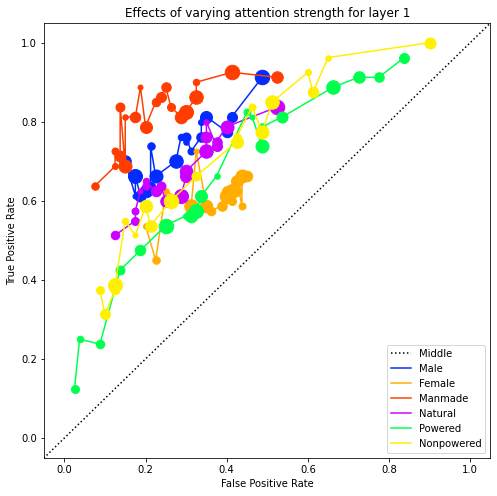

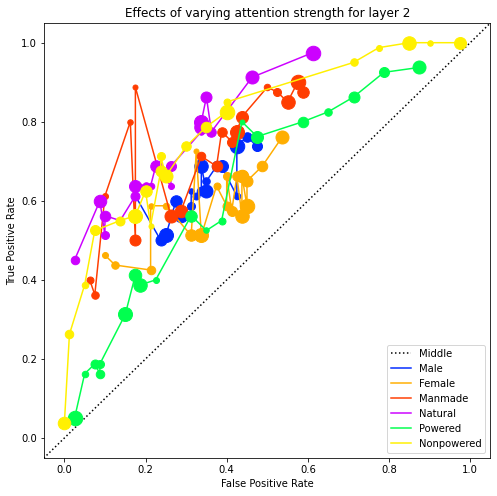

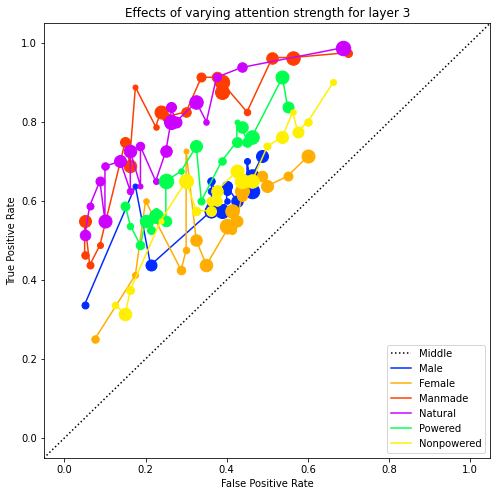

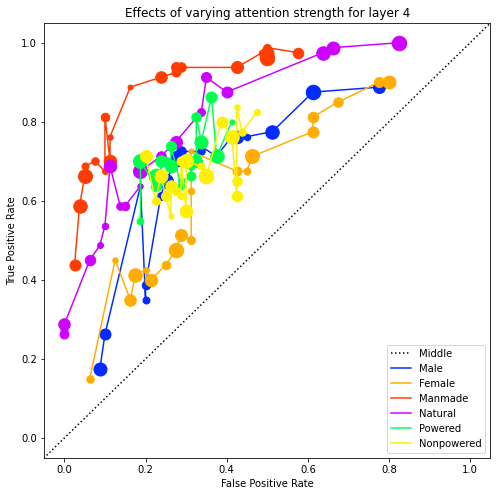

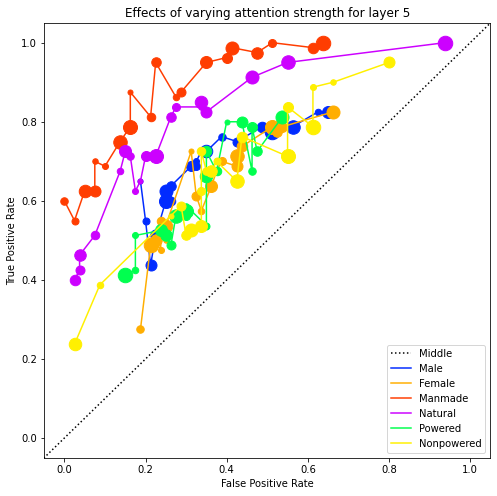

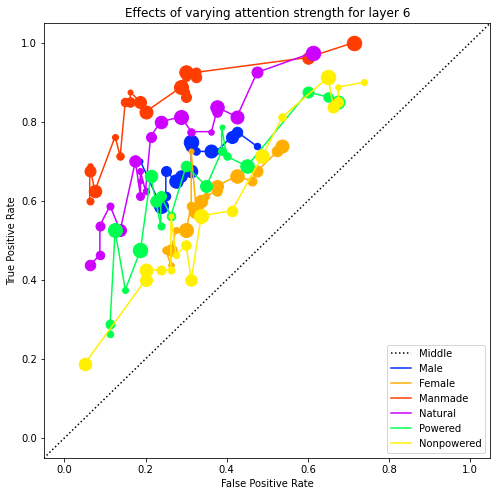

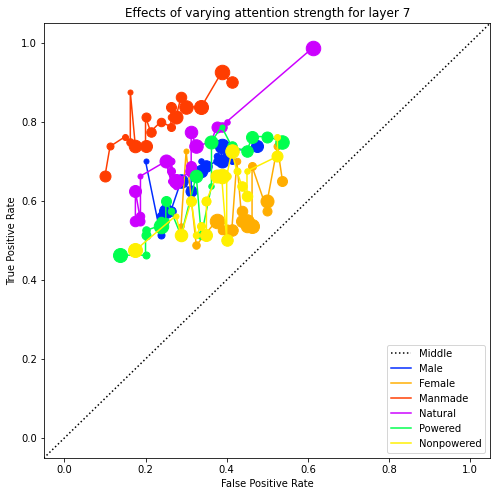

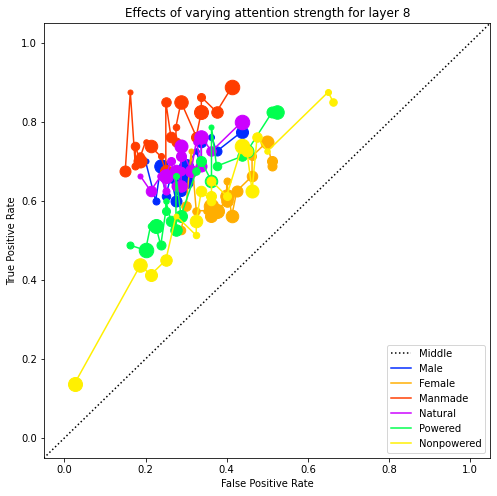

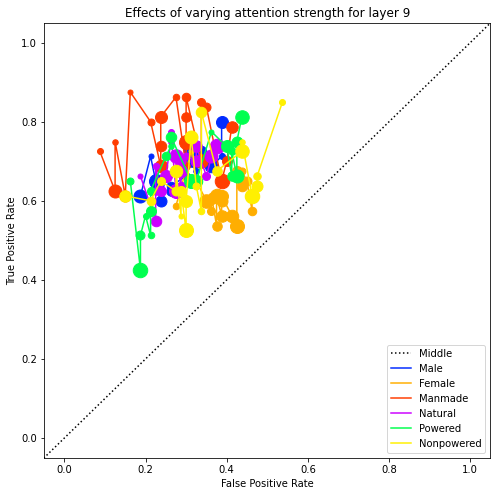

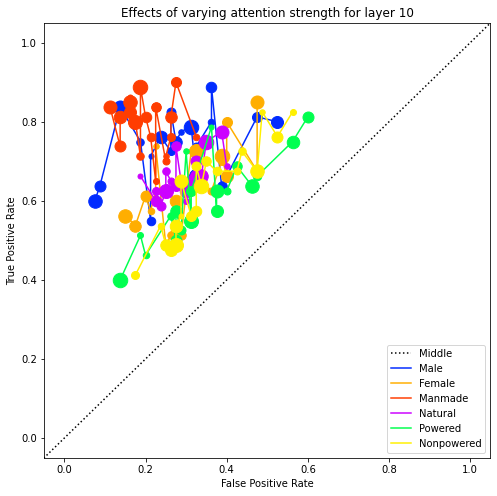

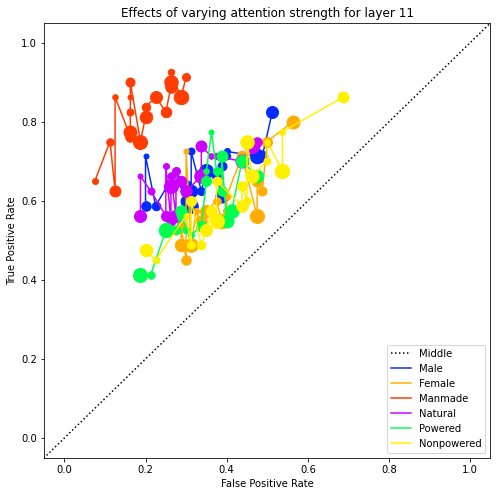

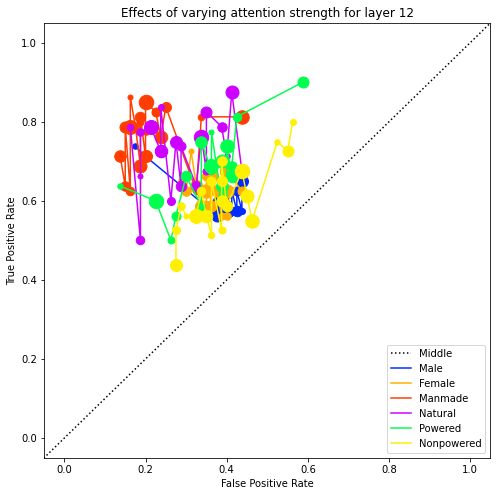

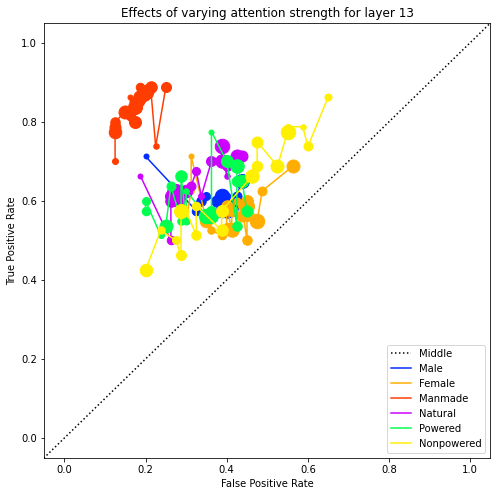

In [ ]:
import matplotlib.pyplot as plt

colors = ['#012bff','#ffae01','#ff3d01','#cc01ff','#01ff4f','#fff001']

for figureNumber in range(13): # iterate over all of the layers
  plt.figure(figsize = (8,8))
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('\u0394 False Positive Rate')
  plt.ylabel('\u0394 True Positive Rate')
  plt.title('Effects of varying attention strength for layer ' + str(figureNumber + 1 ))
  plt.plot([-2,2], [-2,2], ':',label='Middle', color='black')
  for i in range(6):
    markersize = [ 5+(i/2) for i in range(20)]
    processed = list(zip(del_FPR[figureNumber][i], del_TPR[figureNumber][i], markersize))
    sortedProcessed= sorted(processed,key=lambda item: (item[0],item[1]))
    unzipped = list(zip(*sortedProcessed))
    # print(unzipped)
    # print(list(unzipped[0]))
    plt.plot(list(unzipped[0]),list(unzipped[1]), 'k',label=categories[i], color=colors[i])
    for k in range(20):
      plt.plot(sortedProcessed[k][0], sortedProcessed[k][1],'bo', markersize = sortedProcessed[k][2], color=colors[i])
  plt.legend(loc="lower right")
  # plt.savefig(root_directory + 'figures/layer_'+str(figureNumber+1)+'.png')
  # Save the figures using Vggface model +  '/vgg_face'
  plt.savefig(root_directory + '/figures/no_del/layer_'+str(figureNumber+1)+'.png')
plt.show()

### Regular Accuracy
Calculate the regular accuracy so that they can be contrasted against when attention is applied.

In [ ]:
# Reinitialising the models for calculating regular accuracy
model = VGG16(weights='imagenet',
                        include_top=False,input_shape = [224,224,3])

top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:]))
top_model.add(Dense(4096, activation='relu',name = 'top_dense1'))
top_model.add(Dense(1, activation='sigmoid',name = 'predictions'))
top_model.compile(optimizer= Adam(lr=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy'])

categories = ['Male','Female','Manmade','Natural']
acc = [0]*4
for cat in range(ncats):
  tf.keras.backend.clear_session()

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 4]))
  test_it = np.concatenate((data_test[cat],data_test[cat + 4]))
  print(train_it.shape,test_it.shape)


  #plot_model(model,show_shapes=True,expand_nested=True)
  #model.save_weights('vgg_w',save_format='h5')

  features_train = model.predict(train_it)

  features_test = model.predict(test_it)


  epochs = 30
  #train_data = np.load('features_train.npy')
  ntrain = 75
  train_data = features_train
  train_labels = np.array([0] * ntrain + [1]*ntrain)


  #test_data = np.load('features_test.npy')
  ntest = 40
  test_data = features_test
  test_labels = np.array([0] * ntest + [1]*ntest)



  es = EarlyStopping(monitor='loss', mode='min', verbose=1)

  history = top_model.fit(x = train_data,  y = train_labels,
            epochs=epochs,
            batch_size=64,
            verbose = 0, callbacks = [es])

  out = top_model.evaluate(test_data, test_labels)
  print(out)
  acc[cat] = out[1]
  #print('rounded test labels',pred)
np.mean(acc)

# Calculation for control condition

Text(0.5, 0, 'Category')

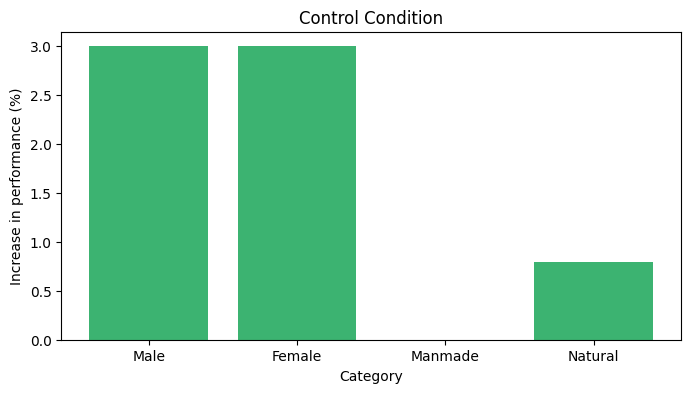

In [ ]:
plt_data = np.array((3,3,0,0.8))
fig = plt.figure(figsize = (8,4))
plt.bar(x = ['Male','Female','Manmade','Natural'],
        height = plt_data.T,
        color = 'mediumseagreen')
plt.title('Control Condition')
plt.ylabel('Increase in performance (%)')
plt.xlabel('Category')


# Plots

### Category wise plot
This code generates the plot for performance increase as a function of category and attention applied at each layer separately.

In [ ]:
acc = [0.69,0.70,0.68,0.58]

gacc = np.load('tun_accuracy_multi0.0.npy')
gacc = np.expand_dims(gacc,0)


for i in np.arange(0.5,10,0.5):
  temp = np.load('tun_accuracy_multi' + str(i) + '.npy')
  temp = np.expand_dims(temp,0)
  gacc = np.vstack((gacc,temp))
#strngs = np.concatenate((strngs,np.arange(1,6,1)))
y = np.amax(gacc,0).T


plt_data = np.zeros((13,4))
for i in range(13):
  for j in range(4):
    plt_data[i,j] = y[i,j] - acc[j]


import seaborn as sns
sns.set(style="white",rc={"lines.linewidth": 1})
sns.set(font_scale=2,style='ticks')
layer = 0
plt.rcParams['figure.dpi'] = 300
f,axes = plt.subplots(2,2,figsize=(15,15))
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Layer",size = 20)
plt.ylabel("Performance Increase (%)",size = 20)
for x in range(2):
  for y in range(2):
    axes[x,y].bar(x = np.arange(0,13),height = plt_data[:,layer]*100,color = 'mediumseagreen')
    axes[x,y].set_xticklabels(np.arange(1,14,2))
    axes[x,y].set_xticks(np.arange(0,14,2))
    axes[x,y].set_title(categories[layer],size = 20)
    axes[x,y].set_ylim(-2,35)
    axes[x,y].set_xlim(-1,13)
    axes[x,y].hlines(y = 0,xmin= -1,xmax = 13)
    axes[x,y].spines['right'].set_visible(False)
    axes[x,y].spines['top'].set_visible(False)
    layer+=1

np.save('merge_set.npy',plt_data)